In [1]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
region_dict = {
    101:'Northeast Climate Region',
    102:'Upper Midwest Climate Region',
    103:'Ohio Valley Climate Region',
    104:'Southeast Climate Region',
    105:'Northern Rockies and Plains Climate Region',
    106:'South Climate Region',
    107:'Southwest Climate Region',
    108:'Northwest Climate Region',
    109:'West Climate Region'
}

In [3]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("../FPA_FOD_20210617.sqlite")

cur = con.cursor()

In [4]:
df = pd.read_sql_query("SELECT region_id, DISCOVERY_DATE FROM Fires", con).dropna()

In [5]:
df.head(10)

,region_id,DISCOVERY_DATE
0,109.0,2/2/2005 0:00
1,109.0,5/12/2004 0:00
2,109.0,5/31/2004 0:00
3,109.0,6/28/2004 0:00
4,109.0,6/28/2004 0:00
5,109.0,6/30/2004 0:00
6,109.0,7/1/2004 0:00
7,109.0,3/8/2005 0:00
8,109.0,3/15/2005 0:00
9,109.0,7/1/2004 0:00


In [6]:
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
df.head()

,region_id,DISCOVERY_DATE
0,109.0,2005-02-02
1,109.0,2004-05-12
2,109.0,2004-05-31
3,109.0,2004-06-28
4,109.0,2004-06-28


In [7]:
per = df.DISCOVERY_DATE.dt.to_period("M")
fires_refactor = df.groupby([per,'region_id']).count()
fires_refactor.head()

DISCOVERY_DATE
DISCOVERY_DATE region_id                
1992-01        101.0                  86
               102.0                   4
               103.0                 119
               104.0                2609
               105.0                  86

In [8]:
fires_refactor.rename(columns={'DISCOVERY_DATE':'count'},inplace=True)
fires_refactor = fires_refactor.reset_index()
fires_refactor.head()

,DISCOVERY_DATE,region_id,count
0,1992-01,101.0,86
1,1992-01,102.0,4
2,1992-01,103.0,119
3,1992-01,104.0,2609
4,1992-01,105.0,86


In [9]:
fires_refactor['month'] = fires_refactor.iloc[:,0].dt.strftime('%m')
fires_refactor.rename(columns={'DISCOVERY_DATE':'date'},inplace=True)
fires_refactor.head()

,date,region_id,count,month
0,1992-01,101.0,86,01
1,1992-01,102.0,4,01
2,1992-01,103.0,119,01
3,1992-01,104.0,2609,01
4,1992-01,105.0,86,01


In [10]:
weather = pd.read_sql_query('select date, region_id, departure_avg_temp, departure_precipitation, departure_max_temp, departure_min_temp from weather',con).dropna()
weather['date'] = pd.to_datetime(weather['date']).dt.to_period("M")
weather.shape

(2817, 6)

In [11]:
data = weather.merge(fires_refactor,how="left",on=["date","region_id"]).fillna(0)
data.shape

(2817, 8)

In [12]:
data.head(20)

,date,region_id,departure_avg_temp,departure_precipitation,departure_max_temp,departure_min_temp,count,month
0,1992-01,101,2.2,-0.68,2.0,2.4,86.0,01
1,1992-02,101,3.2,-0.50,2.4,3.9,130.0,02
2,1992-03,101,-2.3,0.29,-2.5,-2.2,283.0,03
3,1992-04,101,-0.9,-0.76,-1.6,-0.2,743.0,04
4,1992-05,101,-0.6,-0.89,0.3,-1.5,830.0,05
5,1992-06,101,-1.6,-0.46,-1.8,-1.6,227.0,06
6,1992-07,101,-2.7,1.68,-4.0,-1.4,96.0,07
7,1992-08,101,-1.7,0.32,-2.7,-0.8,53.0,08
8,1992-09,101,-0.2,0.14,-0.7,0.2,49.0,09
9,1992-10,101,-3.3,-0.74,-3.9,-2.8,79.0,10


In [13]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [14]:
data = data.astype({'region_id':float,'count':float,'month':float})
data.dtypes


date                       period[M]
region_id                    float64
departure_avg_temp           float64
departure_precipitation      float64
departure_max_temp           float64
departure_min_temp           float64
count                        float64
month                        float64
dtype: object

In [15]:
train_features = data.iloc[:,1:8].sample(frac=0.8, random_state=0)
test_features = data.iloc[:,1:8].drop(train_features.index)

train_labels = train_features.pop('count')
test_labels = test_features.pop('count')
train_features.head()

,region_id,departure_avg_temp,departure_precipitation,departure_max_temp,departure_min_temp,month
1726,106.0,0.8,-0.82,1.0,0.6,6.0
333,102.0,-5.2,-0.15,-6.5,-4.0,9.0
70,101.0,-1.5,1.57,-2.6,-0.5,11.0
569,102.0,0.2,1.96,-0.6,1.0,5.0
118,101.0,6.0,-1.52,7.5,4.5,11.0


In [16]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [17]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [18]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_data=(test_features, test_labels),
    verbose=0, epochs=2500)

Wall time: 3min 19s


In [19]:
test_predictions = dnn_model.predict(test_features).flatten()

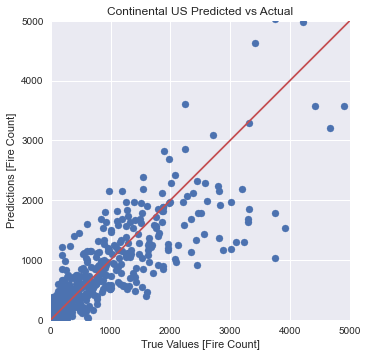

In [21]:

plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Fire Count]')
plt.ylabel('Predictions [Fire Count]')

lims = [0, 5000]
plt.xlim(lims)
plt.ylim(lims)
mpl.style.use('seaborn')
plt.title('Continental US Predicted vs Actual')
_ = plt.plot(lims, lims, 'C2')
plt.savefig('figures/conus_predicted.png')
plt.show()


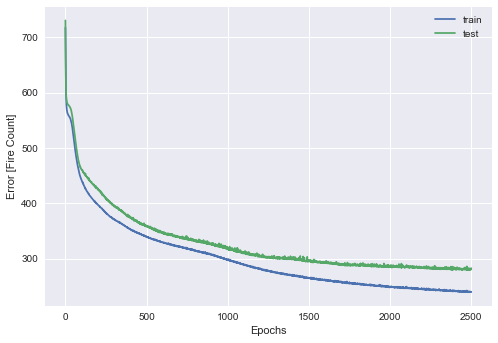

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Error [Fire Count]')
mpl.style.use('seaborn')
plt.savefig('figures/conus_accuracy.png')
plt.show()

In [ ]:
# dnn_model.get_weights()

In [23]:
predict_dict = {}
predict_dict_shift = {}

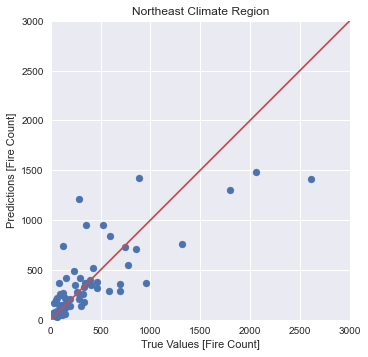

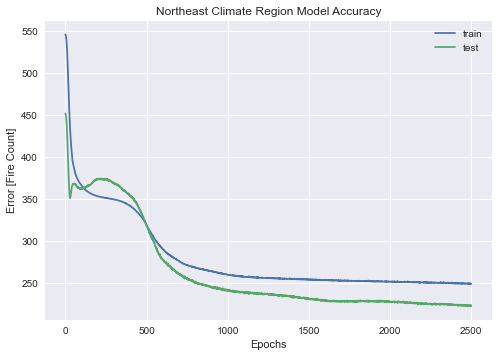

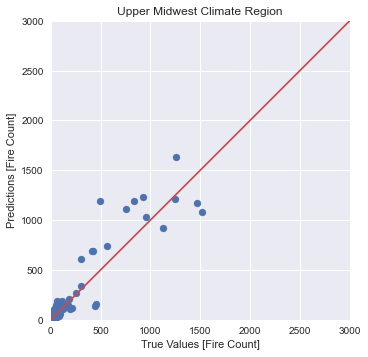

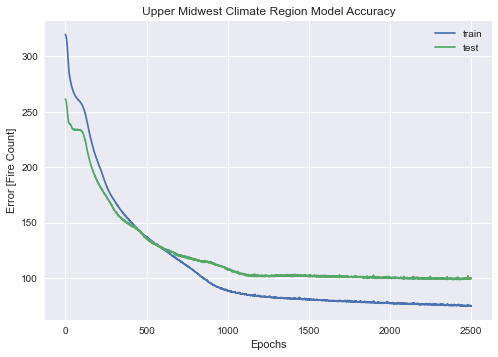

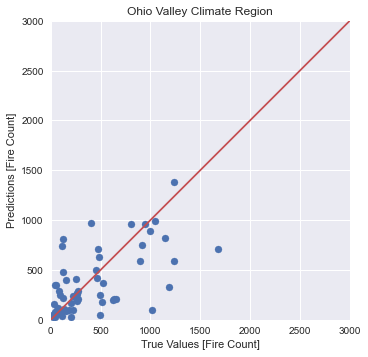

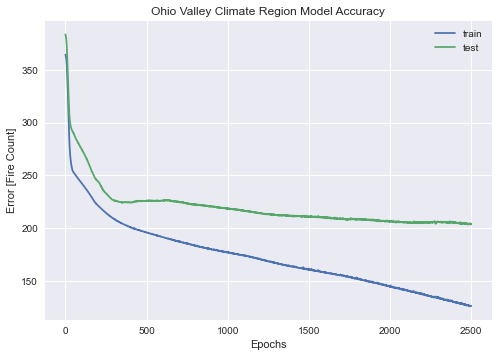

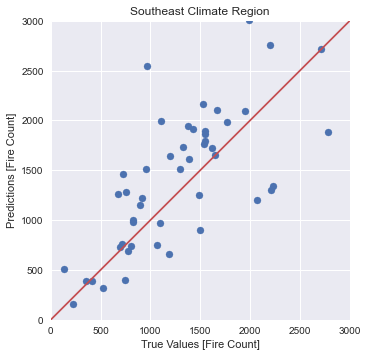

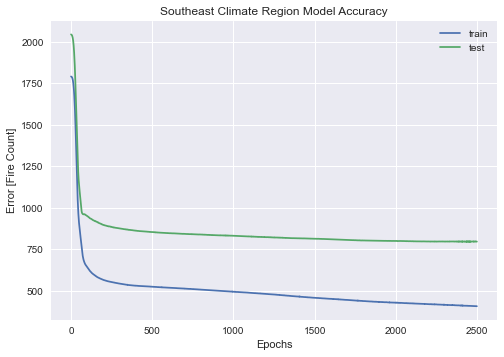

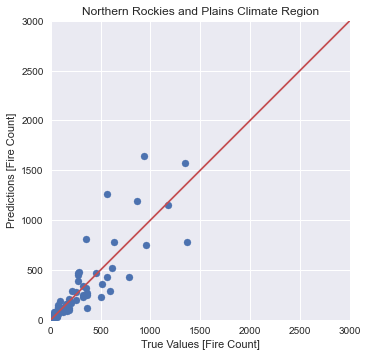

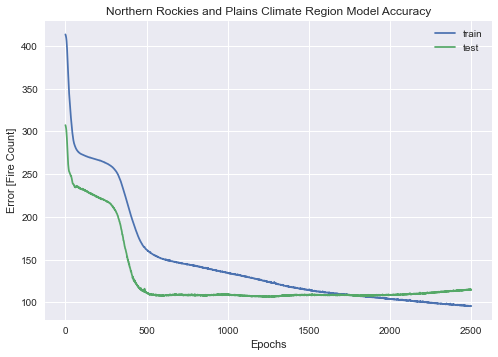

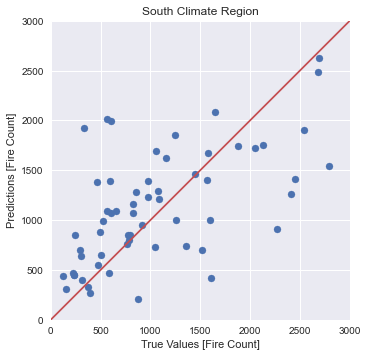

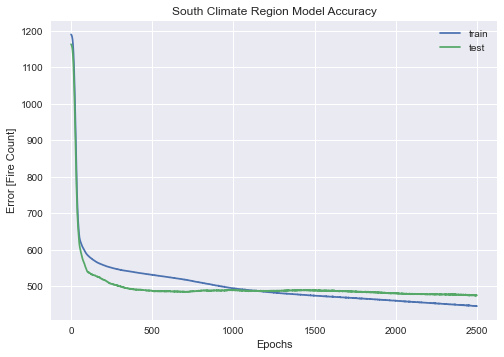

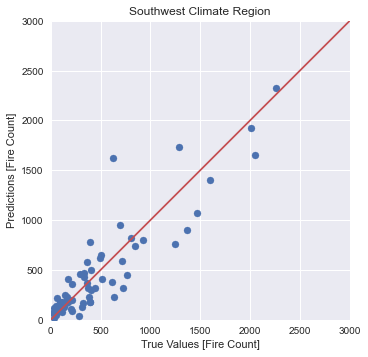

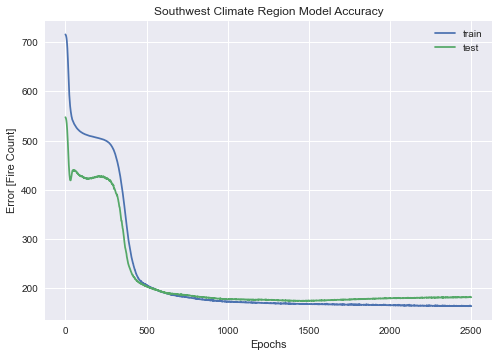

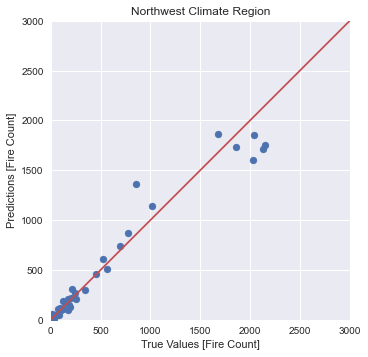

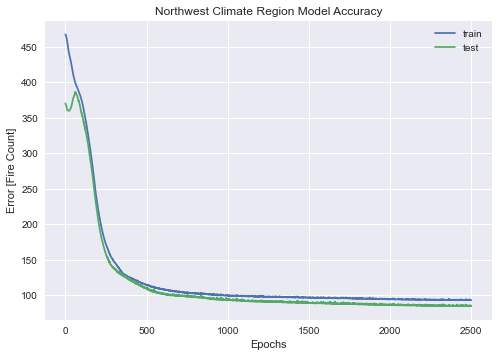

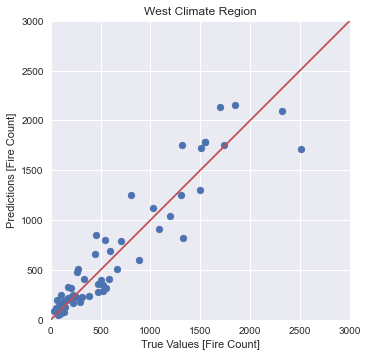

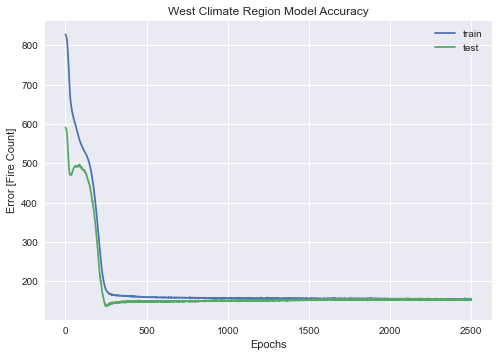

In [24]:
# iterate through rest of regions
for i in range(101,110):
#     reg_data = data[data['region_id']== i]
#     reg_data['count'] = reg_data['count'].shift(-1)
#     reg_data.dropna(inplace=True)
#     train_features = reg_data.iloc[:,2:8].sample(frac=0.8, random_state=1)
#     test_features = reg_data.iloc[:,2:8].drop(train_features.index)

    train_features = data[data['region_id'] == i].iloc[:,2:8].sample(frac=0.8, random_state=1)
    test_features = data[data['region_id'] == i].iloc[:,2:8].drop(train_features.index)

    

    train_labels = train_features.pop('count')
    test_labels = test_features.pop('count')
    
    normalizer = preprocessing.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features))
    
    dnn_model = build_and_compile_model(normalizer)
    history = dnn_model.fit(
    train_features, train_labels,
    validation_data=(test_features, test_labels),
    verbose=0, epochs=2500)
    
    test_predictions = dnn_model.predict(test_features).flatten()
    
    predict_dict[i]= [test_labels,test_predictions]
    
    plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [Fire Count]')
    plt.ylabel('Predictions [Fire Count]')
    plt.title(region_dict[i])

    lims = [0, 3000]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.grid(True)
    mpl.style.use('seaborn')
    _ = plt.plot(lims, lims, 'C2')
    plt.savefig(f"figures/predictions {region_dict[i]}.png")
    plt.show()
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title(region_dict[i]+" Model Accuracy")
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Error [Fire Count]')
    mpl.style.use('seaborn')
    plt.savefig(f"figures/accuracy {region_dict[i]}.png" )
    plt.show()


In [60]:
predict_df = pd.DataFrame()
for x in predict_dict:
    actual = predict_dict[x][0].tolist()
    predicted = list(predict_dict[x][1])
    df = pd.DataFrame({'actual':actual,'predicted':predicted})
    df['region_id'] = x
    predict_df = predict_df.append(df)
#     df['region_id'] = x
predict_df.head()
predict_df.to_csv('departure_model_test_output.csv',index=False)

In [ ]:
con.close()